# Introduction

In this notebook, I would like to investigate the use of pairwise covariance matrices to impute data.

## Simulated Data

First off, let's simulate data drawn from a multivariate normal. Three columns of data, columns A, B, and C, for which we know the ground-truth covariance matrix between all 3.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import janitor
import numpy_sugar as ns

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
def extract_diagonal(M):
    diag = np.zeros((M.shape[0], M.shape[1]))
    np.fill_diagonal(diag, np.diagonal(M))
    return diag

In [21]:
n_variates = 5
triangle = np.random.random(size=(n_variates, n_variates))
cov = np.triu(triangle, k=1) + np.triu(triangle, k=1).T + extract_diagonal(triangle)

mean = np.random.random(size=(n_variates))

In [22]:
cov

array([[0.31385228, 0.60977505, 0.72741806, 0.60740167, 0.81248334],
       [0.60977505, 0.37355032, 0.82427794, 0.85385602, 0.66121006],
       [0.72741806, 0.82427794, 0.12075115, 0.82780063, 0.22315742],
       [0.60740167, 0.85385602, 0.82780063, 0.03651504, 0.26919202],
       [0.81248334, 0.66121006, 0.22315742, 0.26919202, 0.23555706]])

In [23]:
ns.linalg.check_semidefinite_positiveness(cov)

False

In [24]:
np.linalg.cond(cov)

13.486262364904109

In [25]:
data = np.random.multivariate_normal(mean=mean, cov=cov, size=10_000_000)
df = pd.DataFrame(data)

/home/ericmjl/anaconda/envs/bayesian/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  after removing the cwd from sys.path.


In [17]:
data.shape

(10000000, 3)

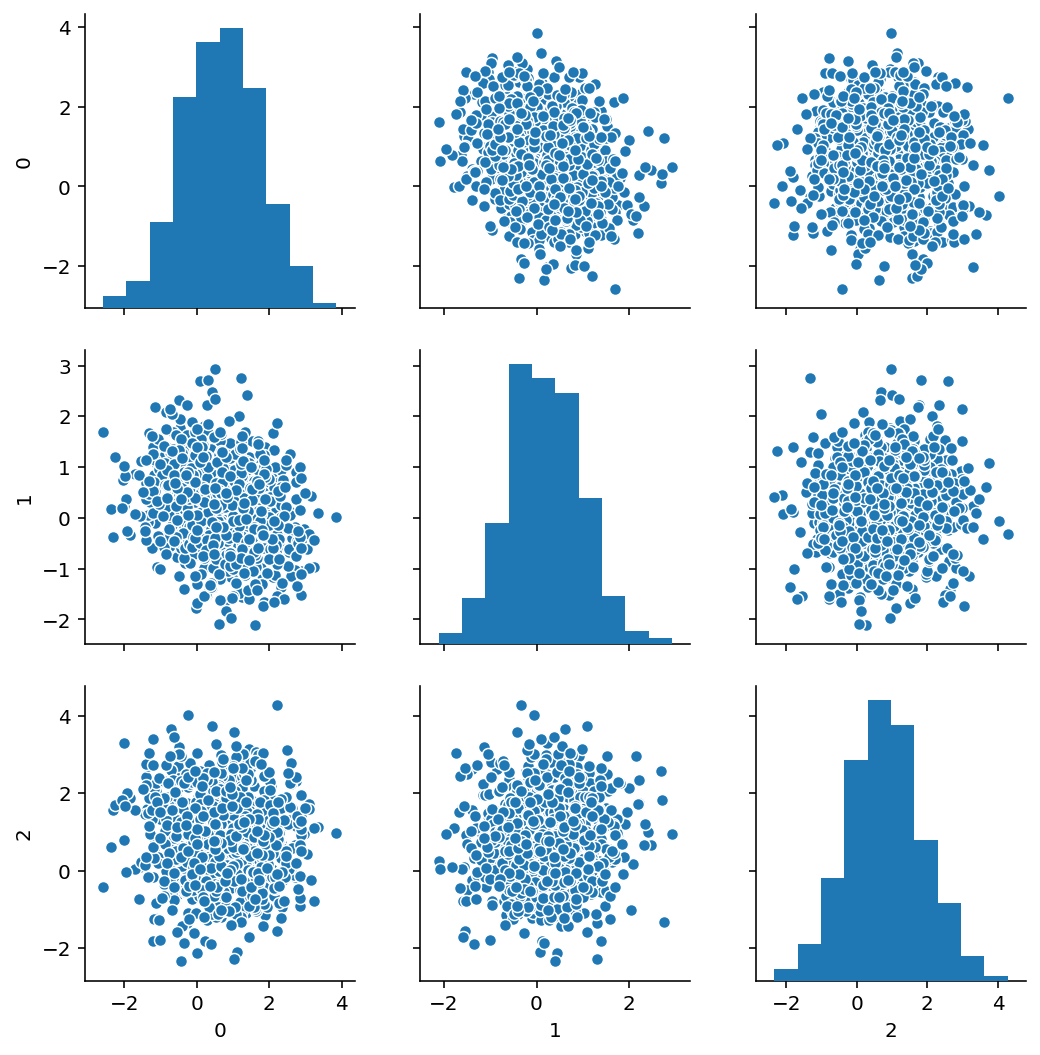

In [18]:
sns.pairplot(pd.DataFrame(data).sample(1000))

Now, let's simulate the case where a dropout mask is applied on 99% of the data.

In [9]:
mask = np.random.binomial(n=1, p=0.01, size=data.shape)

In [10]:
ind = np.where(mask.flatten() == 0)
ind

(array([       0,        1,        2, ..., 49999997, 49999998, 49999999]),)

In [11]:
data_masked = mask * data

In [12]:
np.put(data_masked, ind, np.nan)

In [13]:
pd.DataFrame(data_masked)

0         1         2         3         4
0       NaN       NaN       NaN       NaN       NaN
1       NaN       NaN       NaN       NaN       NaN
2       NaN       NaN       NaN       NaN       NaN
3       NaN       NaN       NaN       NaN       NaN
4       NaN       NaN       NaN       NaN       NaN
5       NaN       NaN       NaN       NaN       NaN
6       NaN       NaN       NaN       NaN       NaN
7       NaN       NaN       NaN       NaN       NaN
8       NaN       NaN -2.798164       NaN       NaN
9       NaN       NaN       NaN       NaN       NaN
10      NaN       NaN       NaN       NaN       NaN
11      NaN       NaN       NaN       NaN       NaN
12      NaN       NaN       NaN  0.401382       NaN
13      NaN       NaN       NaN       NaN       NaN
14      NaN       NaN       NaN       NaN       NaN
15      NaN       NaN       NaN       NaN       NaN
16      NaN       NaN       NaN       NaN       NaN
17      NaN       NaN       NaN       NaN       NaN
18      NaN       NaN       NaN       NaN       NaN
19      NaN       NaN       NaN       NaN       NaN
20      NaN       NaN       NaN       NaN  0.452437
21      NaN       NaN       NaN       NaN       NaN
22      NaN       NaN       NaN       NaN       NaN
23      NaN       NaN       NaN       NaN       NaN
24      NaN       NaN       NaN       NaN       NaN
25      NaN       NaN       NaN       NaN       NaN
26      NaN       NaN       NaN       NaN       NaN
27      NaN       NaN       NaN       NaN       NaN
28      NaN       NaN       NaN       NaN       NaN
29      NaN       NaN       NaN       NaN       NaN
...      ..       ...       ...       ...       ...
9999970 NaN       NaN       NaN       NaN       NaN
9999971 NaN       NaN       NaN       NaN       NaN
9999972 NaN       NaN       NaN       NaN       NaN
9999973 NaN       NaN       NaN       NaN       NaN
9999974 NaN       NaN       NaN       NaN       NaN
9999975 NaN       NaN       NaN       NaN       NaN
9999976 NaN       NaN       NaN       NaN       NaN
9999977 NaN  0.638708       NaN       NaN       NaN
9999978 NaN       NaN       NaN       NaN       NaN
9999979 NaN       NaN       NaN       NaN       NaN
9999980 NaN       NaN       NaN       NaN       NaN
9999981 NaN       NaN       NaN       NaN       NaN
9999982 NaN       NaN       NaN       NaN       NaN
9999983 NaN       NaN       NaN       NaN       NaN
9999984 NaN       NaN       NaN       NaN       NaN
9999985 NaN       NaN       NaN       NaN       NaN
9999986 NaN       NaN       NaN       NaN       NaN
9999987 NaN       NaN       NaN       NaN       NaN
9999988 NaN       NaN       NaN       NaN       NaN
9999989 NaN       NaN       NaN       NaN       NaN
9999990 NaN       NaN       NaN       NaN       NaN
9999991 NaN       NaN       NaN       NaN       NaN
9999992 NaN       NaN       NaN       NaN       NaN
9999993 NaN       NaN       NaN       NaN       NaN
9999994 NaN       NaN       NaN       NaN       NaN
9999995 NaN       NaN       NaN       NaN       NaN
9999996 NaN       NaN       NaN       NaN       NaN
9999997 NaN       NaN       NaN       NaN       NaN
9999998 NaN       NaN       NaN       NaN       NaN
9999999 NaN       NaN       NaN       NaN       NaN

[10000000 rows x 5 columns]

In [14]:
import missingno as msno

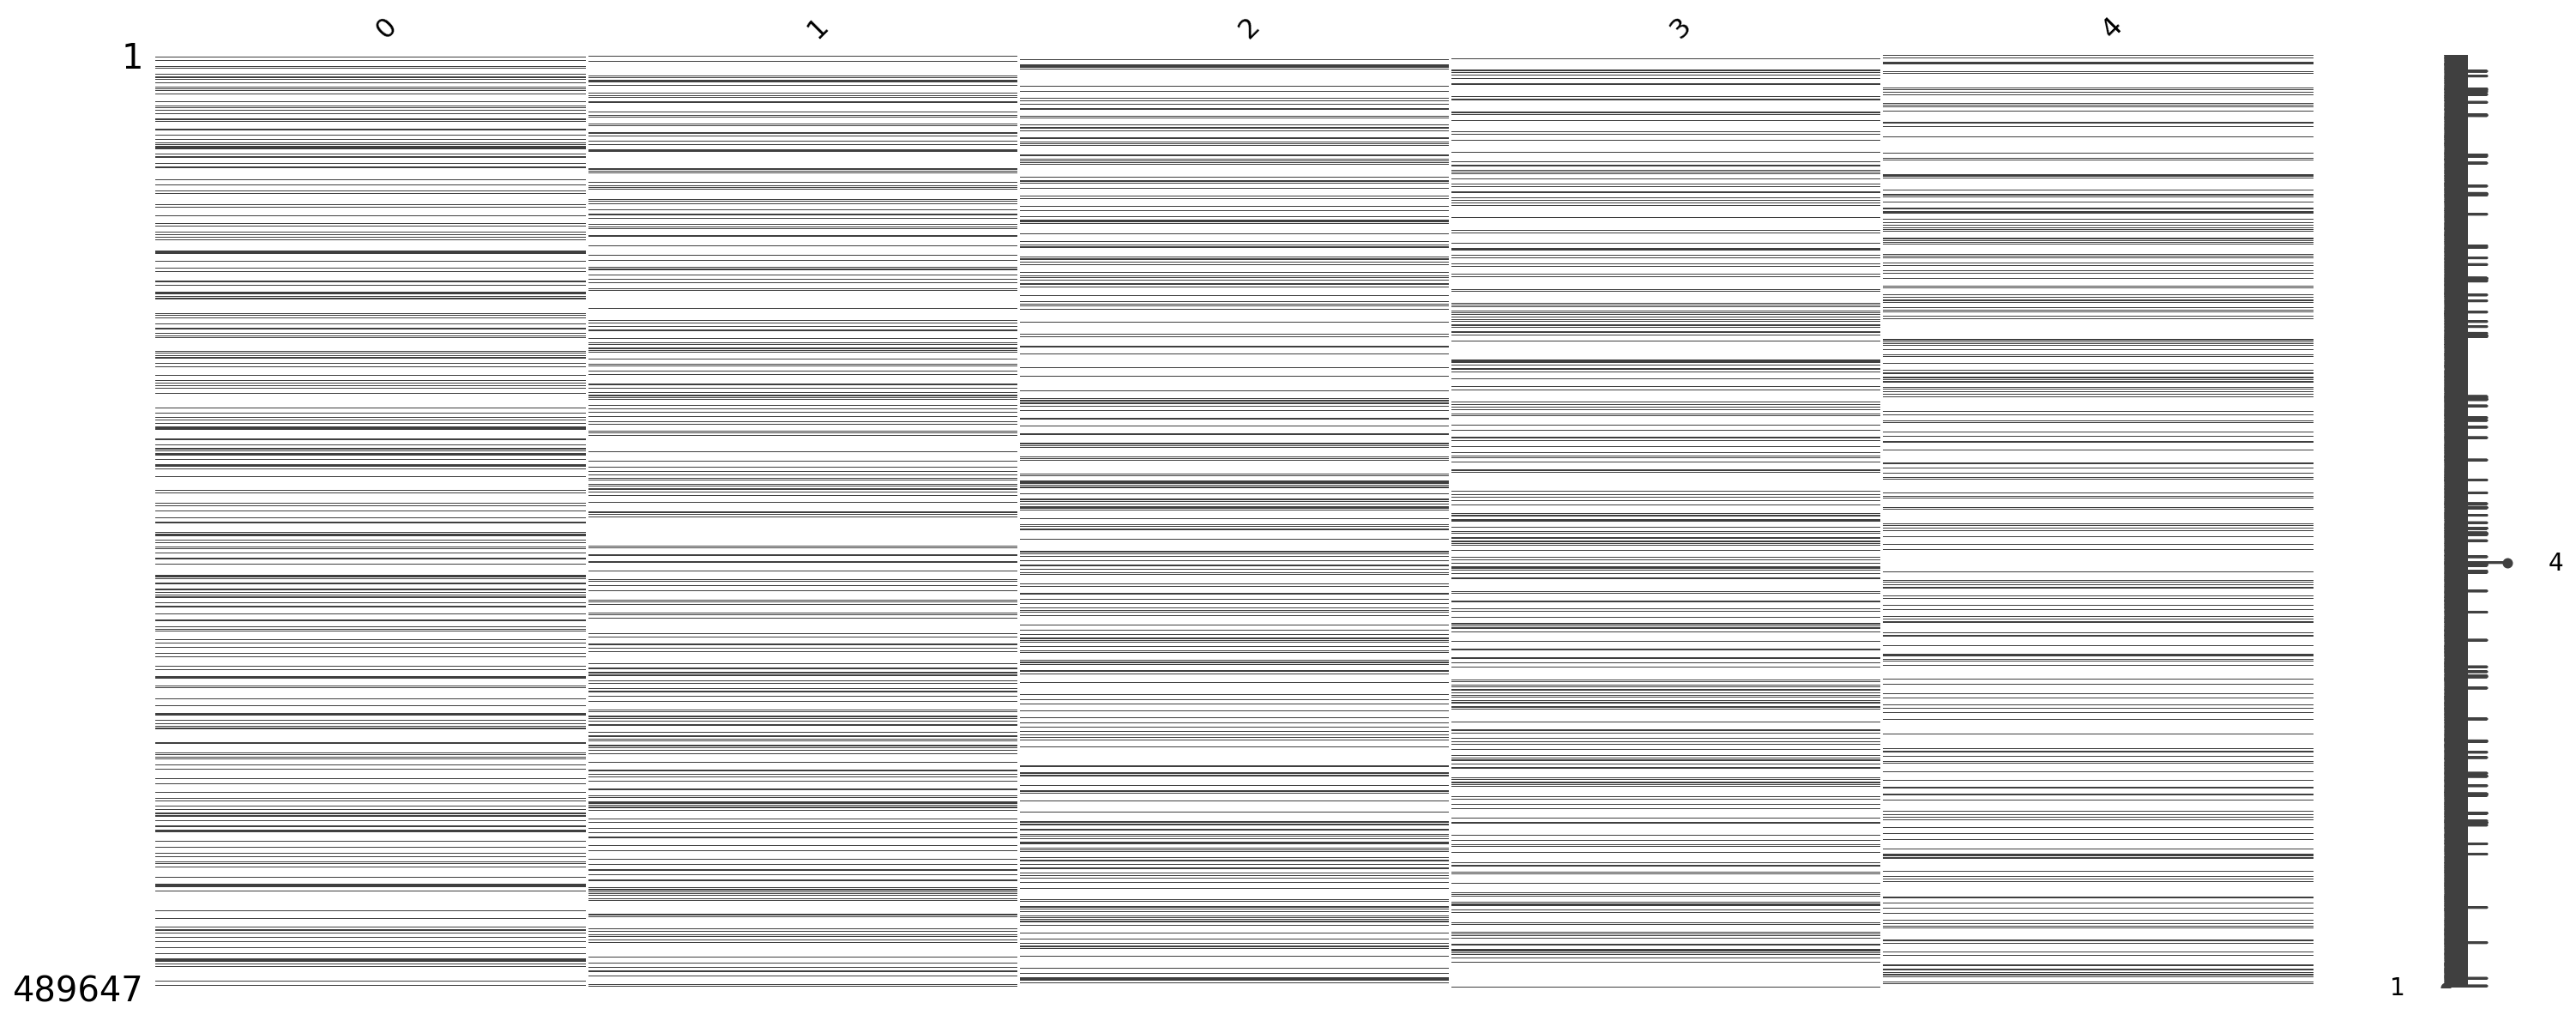

In [15]:
df_masked = pd.DataFrame(data_masked).dropna(how="all")
msno.matrix(df_masked)

In [16]:
import janitor

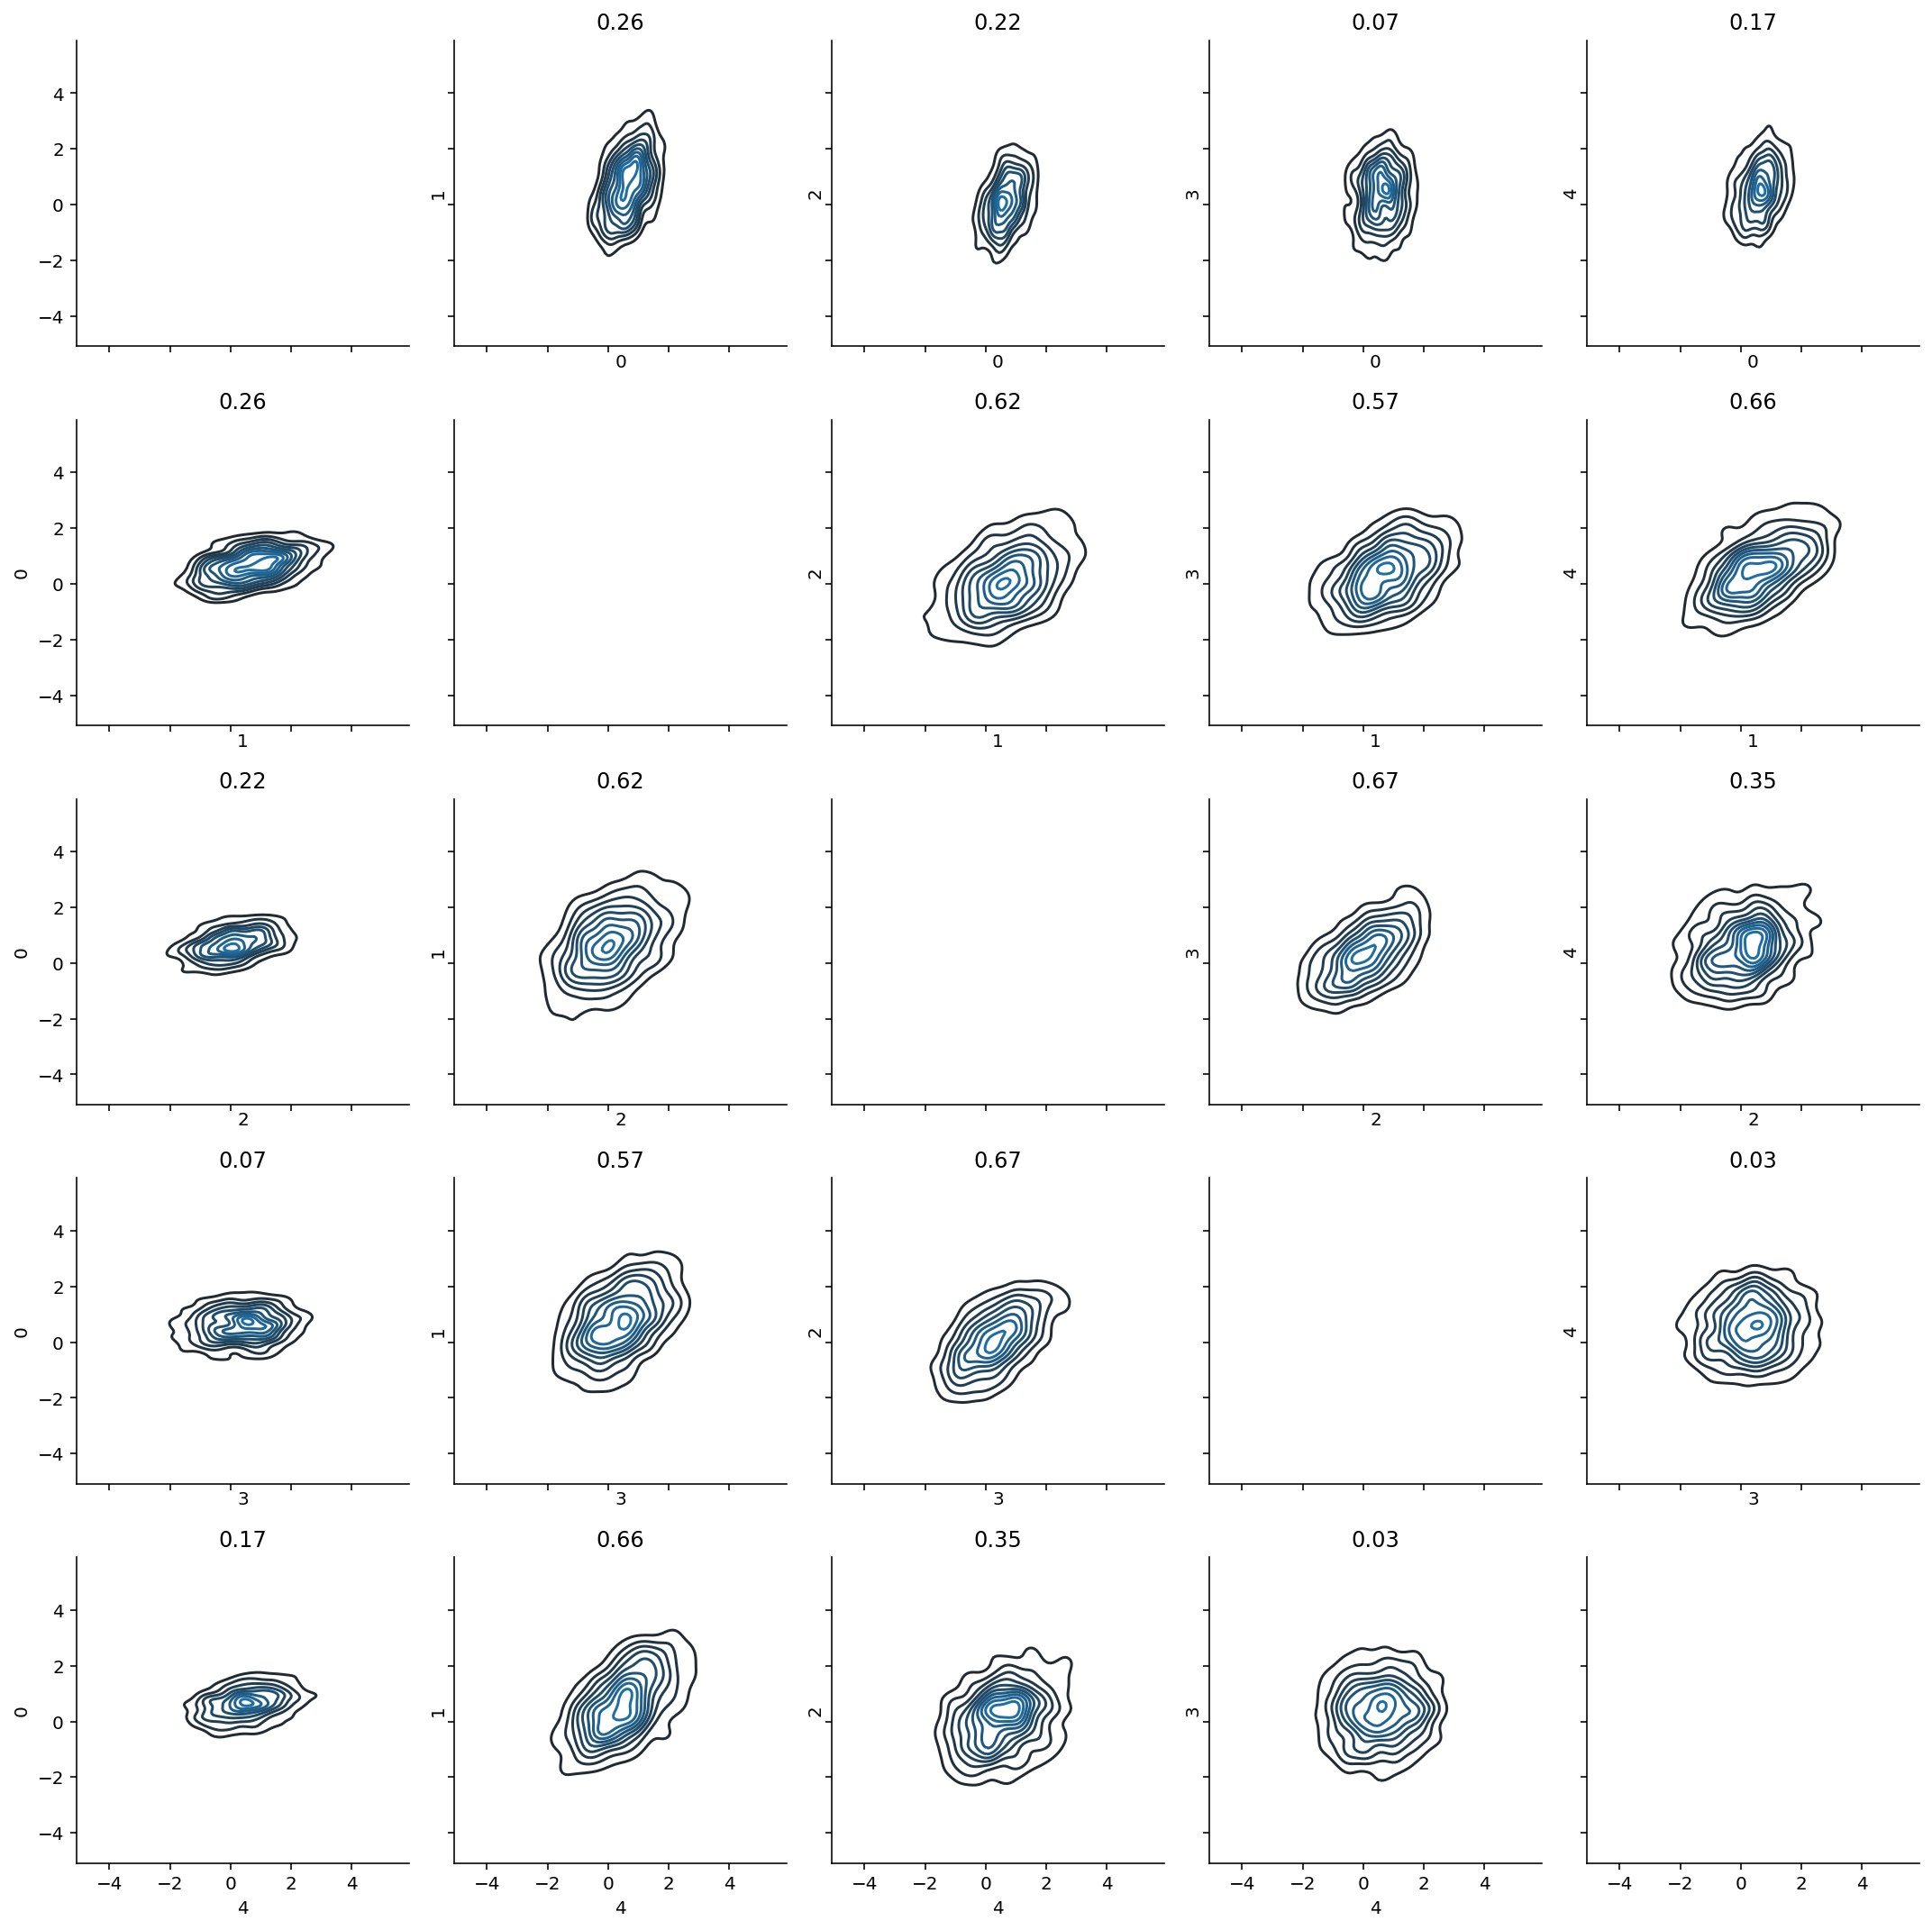

In [17]:
from itertools import combinations
import seaborn as sns

fig, ax = plt.subplots(
    figsize=(15, 15), nrows=n_variates, ncols=n_variates, sharex=True, sharey=True
)

covars = dict()
for r, c in combinations(df_masked.columns, 2):
    df_filtered = df_masked[[r, c]].dropna()
    sns.kdeplot(data=df_filtered[r], data2=df_filtered[c], ax=ax[r, c])
    sns.kdeplot(data=df_filtered[c], data2=df_filtered[r], ax=ax[c, r])
    # ax[r, c].scatter(df_filtered[r], df_filtered[c])
    # ax[c, r].scatter(df_filtered[c], df_filtered[r])
    covar = np.cov(df_filtered.T)
    ax[r, c].set_title(f"{covar[0, 1]:.2f}")
    ax[c, r].set_title(f"{covar[1, 0]:.2f}")

    covars[(r, c)] = covar
    covars[(c, r)] = covar
plt.tight_layout()

Now, let's say I have a new sample for which I only have data from column 0 and 1. Can we combine this information in a mathematically principled fashion so as to recover measurement of column 2 with uncertainty?

In [192]:
df_unknown2 = df_masked.dropna(subset=[0, 1], how="any").dropnotnull(4)

In [194]:
df_unknown2

0         1   2   3   4
10408    0.150532 -0.824141 NaN NaN NaN
21632   -0.633014 -1.330958 NaN NaN NaN
22373    0.190275  0.582273 NaN NaN NaN
30425    1.414987  1.098055 NaN NaN NaN
30532    1.233849  1.219678 NaN NaN NaN
36693   -0.080780  0.247758 NaN NaN NaN
41566    0.544910  0.400895 NaN NaN NaN
43481   -0.556573 -0.116066 NaN NaN NaN
51806    1.394208  0.400142 NaN NaN NaN
53024   -0.060240  0.649141 NaN NaN NaN
53521    0.098345  0.651847 NaN NaN NaN
64388    0.214834  0.288168 NaN NaN NaN
65455    0.188987  2.210882 NaN NaN NaN
69079   -0.177311  0.837440 NaN NaN NaN
72535    0.281063 -0.821823 NaN NaN NaN
82738    1.499099  1.467776 NaN NaN NaN
99940   -0.512536  0.625783 NaN NaN NaN
102305  -0.823691  0.131851 NaN NaN NaN
106290   0.180568  0.954643 NaN NaN NaN
110245   0.296120  0.667118 NaN NaN NaN
113508   0.552421  1.179006 NaN NaN NaN
114147   0.515503  1.542826 NaN NaN NaN
116248  -0.483769  0.022975 NaN NaN NaN
118659   1.076577  0.464541 NaN NaN NaN
120661   1.189426  0.784823 NaN NaN NaN
135527   0.142996  2.134528 NaN NaN NaN
136704   1.672772  1.503659 NaN NaN NaN
139305   1.575195  1.734410 NaN NaN NaN
144897  -0.167003 -0.053584 NaN NaN NaN
148376   0.603210  0.586169 NaN NaN NaN
...           ...       ...  ..  ..  ..
9725759 -0.707598 -0.587958 NaN NaN NaN
9726548  1.185876  1.779096 NaN NaN NaN
9747191  0.683025 -0.008996 NaN NaN NaN
9747227  1.313317  1.477510 NaN NaN NaN
9756678  0.545202  0.221479 NaN NaN NaN
9791571  0.728944  0.731200 NaN NaN NaN
9791794  0.521416 -0.310239 NaN NaN NaN
9804825  1.083765  2.192027 NaN NaN NaN
9822195  1.697781  1.014138 NaN NaN NaN
9823444  0.899078  1.393480 NaN NaN NaN
9830622  1.199563  2.835362 NaN NaN NaN
9838145 -0.332150 -1.717382 NaN NaN NaN
9840261  0.016191  0.370368 NaN NaN NaN
9853963  1.019612  0.616737 NaN NaN NaN
9863175  0.566761 -0.237526 NaN NaN NaN
9878132  1.110619  1.613041 NaN NaN NaN
9883894  0.591284  0.589175 NaN NaN NaN
9898164 -0.082350 -1.286007 NaN NaN NaN
9913326 -0.534079 -1.015613 NaN NaN NaN
9916607  1.453102  2.050743 NaN NaN NaN
9929369 -0.302568  0.630793 NaN NaN NaN
9931453  0.889155  0.115024 NaN NaN NaN
9934536  0.958179  1.030260 NaN NaN NaN
9939725  0.663100  1.805827 NaN NaN NaN
9943698  1.109493  1.330724 NaN NaN NaN
9947590  0.278072  1.129739 NaN NaN NaN
9961827  0.932653  1.550669 NaN NaN NaN
9987447  0.991985  1.370655 NaN NaN NaN
9994367  1.132825  0.149756 NaN NaN NaN
9996457  1.200752  0.880499 NaN NaN NaN

[967 rows x 5 columns]

In [195]:
from pprint import pprint

pprint(covars)

{(0, 1): array([[0.55801982, 0.42593982],
       [0.42593982, 0.79690886]]),
 (0, 2): array([[0.5771407 , 0.65885873],
       [0.65885873, 1.30846317]]),
 (0, 3): array([[0.55548822, 0.30514159],
       [0.30514159, 1.02738112]]),
 (0, 4): array([[0.5950965, 0.555712 ],
       [0.555712 , 0.8529676]]),
 (1, 0): array([[0.55801982, 0.42593982],
       [0.42593982, 0.79690886]]),
 (1, 2): array([[0.75555095, 0.44113883],
       [0.44113883, 1.28036146]]),
 (1, 3): array([[0.76744565, 0.48366567],
       [0.48366567, 1.04773716]]),
 (1, 4): array([[0.77515802, 0.23183727],
       [0.23183727, 0.86264261]]),
 (2, 0): array([[0.5771407 , 0.65885873],
       [0.65885873, 1.30846317]]),
 (2, 1): array([[0.75555095, 0.44113883],
       [0.44113883, 1.28036146]]),
 (2, 3): array([[1.36156702, 0.43711758],
       [0.43711758, 1.08436579]]),
 (2, 4): array([[1.43547879, 0.83495197],
       [0.83495197, 0.95011231]]),
 (3, 0): array([[0.55548822, 0.30514159],
       [0.30514159, 1.02738112]]),
 (3

By the fundamental rule of multivariate normals, if we have a bivariate Normal distribution:

$$ X_1 X_2 \sim N(\mu, \Sigma)$$

Then if we know the value of $X_2=x_2$, then $X_1$ follows a distribution:

$$ X_1 \sim N(\mu_{1|2}, \Sigma_{1|2})$$

where 

$$\mu_{1|2} = \mu_1 + \Sigma_{12}\Sigma^{-1}_{22}(x_2-\mu_2)$$

and

$$\Sigma_{1|2} = \Sigma_{11} - \Sigma_{12} \Sigma^{-1}_{22} \Sigma_{21}$$

Thanks to the magic of Python, we can encode this in a function. Given two columns of data, we can estimate $\mu_1$ and $\mu_2$ and the covariance matrix $\Sigma$.

In [ ]:
def mu_cond(mu, sig, x):
    """
    Compute Gaussian mean conditioned on x (observed data).
    
    x should always have fewer entries than mu, and is assumed to 
    be aligned with the last set of entries in mu and sig.
    """

In [21]:
mu = df_masked.mean().values
mu

array([-1.45063357e-03,  5.99798988e+00,  2.00441501e+00])

In [22]:
covars[(0, 2)]

# sigma = np.cov()

array([[0.94225467, 0.8582759 ],
       [0.8582759 , 0.98306504]])

In [23]:
def mu_2g1(mu: np.ndarray, cov: np.ndarray, x_1: float):
    """
    :param mu: length-2 vector of mus.
    :param cov: 2x2 square covariance matrix.
    :param x_2: Known measurement.
    """
    sigma_21 = cov[1, 0]
    sigma_11 = cov[0, 0]
    mu_1 = mu[0]
    mu_2 = mu[1]
    return mu_2 + sigma_21 * 1 / sigma_11 * (x_1 - mu_1)


idx = df_unknown2.index[0]
print(mu_2g1(mu[[0, 2]], covars[(0, 2)], x_1=df_unknown2.loc[idx, 0]))
print(mu_2g1(mu[[1, 2]], covars[(1, 2)], x_1=df_unknown2.loc[idx, 1]))

2.9551250551293626
2.3160394305415353


In [24]:
def sig_2g1(cov):
    """
    :param cov: 2x2 covariance matrix.
    """
    if not cov.shape == (2, 2):
        raise ValueError("cov must be a 2x2 matrix")
    return cov[1, 1] - cov[1, 0] * 1 / cov[0, 0] * cov[0, 1]


pprint(sig_2g1(covars[(0, 2)]))
pprint(sig_2g1(covars[(1, 2)]))

0.2012832632484679
0.3392207734774968


In [25]:
df_masked[[0, 2]].mean().values

array([-1.45063357e-03,  2.00441501e+00])

In [26]:
def mu_sig(known_col, unknown_col):
    idx = df_unknown2.index[0]
    x_known = df_unknown2.loc[idx, known_col]
    mu = df_masked[[known_col, unknown_col]].mean().values
    cov = covars[(known_col, unknown_col)]
    mu = mu_2g1(mu, cov, x_known)
    sig = sig_2g1(cov)
    return mu, sig

In [27]:
mu_sig(0, 2)

(2.9551250551293626, 0.2012832632484679)

In [28]:
mu_sig(1, 2)

(2.3160394305415353, 0.3392207734774968)

In [29]:
from scipy.stats import norm

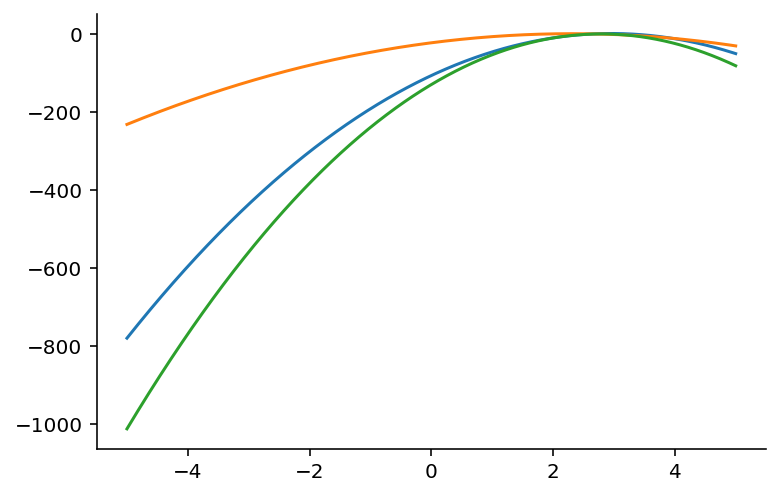

In [30]:
x = np.linspace(-5, 5, 1000)
logpdf1 = norm(*mu_sig(0, 2)).logpdf(x)
pdf1 = norm(*mu_sig(0, 2)).pdf(x)

logpdf2 = norm(*mu_sig(1, 2)).logpdf(x)
pdf2 = norm(*mu_sig(1, 2)).pdf(x)

plt.plot(x, logpdf1)
plt.plot(x, logpdf2)
plt.plot(x, logpdf1 + logpdf2)

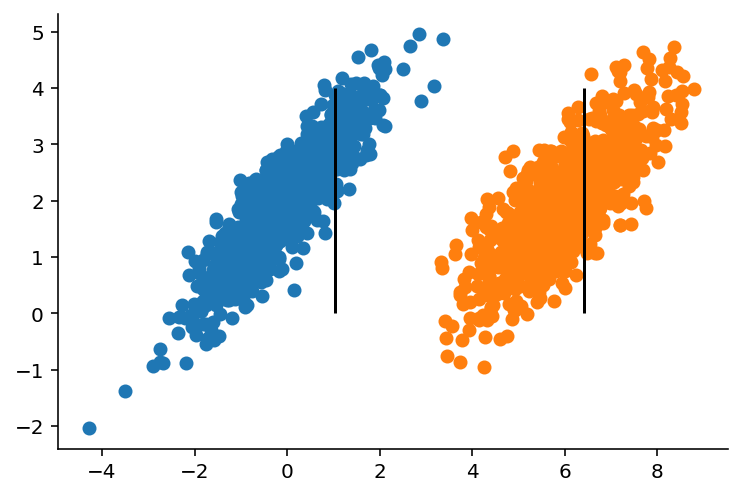

In [31]:
r = 0
c = 2
df_filtered = df_masked[[r, c]].dropna()
plt.scatter(*df_filtered.T.values)
plt.vlines(x=df_unknown2.loc[idx, r], ymin=0, ymax=4)

r = 1
c = 2
df_filtered = df_masked[[r, c]].dropna()
plt.scatter(*df_filtered.T.values)
plt.vlines(x=df_unknown2.loc[idx, r], ymin=0, ymax=4)

In [32]:
idx = df_unknown2.index[0]
df.loc[idx]

0    1.042282
1    6.409348
2    3.211660
Name: 2282, dtype: float64

In [33]:
sumlogpdf = logpdf1 + logpdf2
x[np.where(sumlogpdf == sumlogpdf.max())]

array([2.78778779])

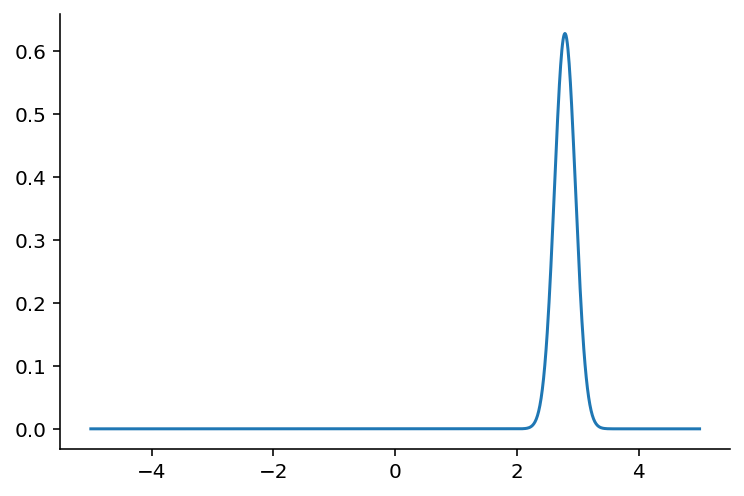

In [35]:
plt.plot(x, pdf1 * pdf2)

It works! We can use fully probabilistic methods that are mathematically principled to obtain estimates of unknown data, given that we know the joint distribution.